# 가구 multi label classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T
import timm

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# data

In [3]:
annotaions_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/9/data/annotations.csv')
annotaions_df

,filename,desk,sofa,brown,white,black
0,brown_sofa/brown_sofa_162.jpg,0,1,1,0,0
1,brown_sofa/brown_sofa_176.jpg,0,1,1,0,0
2,brown_sofa/brown_sofa_86.jpg,0,1,1,0,0
3,brown_sofa/brown_sofa_92.jpg,0,1,1,0,0
4,brown_sofa/brown_sofa_79.jpg,0,1,1,0,0
...,...,...,...,...,...,...
1045,white_sofa/white_sofa_144.jpg,0,1,0,1,0
1046,white_sofa/white_sofa_150.jpg,0,1,0,1,0
1047,white_sofa/white_sofa_178.jpg,0,1,0,1,0
1048,white_sofa/white_sofa_187.jpg,0,1,0,1,0


# CustomDataset

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, annotaions_df, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i in range(annotaions_df.shape[0]):
            img_path = os.path.join(root_path, annotaions_df.iloc[i, 0])
            labels = torch.tensor(annotaions_df.iloc[i, 1:].tolist()).float()
            self.data.append((img_path, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        labels = self.data[idx][1]

        return img, labels

In [9]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

total_datset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter3/9/data', annotaions_df, transforms)

In [11]:
total_num = len(total_datset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_datset, [train_num, valid_num, test_num])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# training, evaluation

In [15]:
def training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        preds = (torch.sigmoid(outputs)>threshold).float()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_f1

def evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = (torch.sigmoid(outputs)>threshold).float()

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, threshold, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1 = evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train F1: {train_f1}, Valid Loss: {valid_loss}, Valid F1: {valid_f1}')

    return model

# model

In [13]:
model = timm.create_model(
    'efficientnet_b4',
    num_classes = 5,
    pretrained=True
)
model

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [16]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, 0.5, 20)

  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.31965139961608174, Train F1: 0.8003411721790746, Valid Loss: 0.1734942884317466, Valid F1: 0.9107709774676168


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.05277335414452092, Train F1: 0.9768811361012066, Valid Loss: 0.20301032226000512, Valid F1: 0.8970101421337681


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.035934018329190055, Train F1: 0.9846079029815458, Valid Loss: 0.17750146772180284, Valid F1: 0.8773220203739577


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0316618378164317, Train F1: 0.9827111654889247, Valid Loss: 0.22195509235773767, Valid F1: 0.9105229513831665


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.038213927096704826, Train F1: 0.9827284257792466, Valid Loss: 0.21300664597323962, Valid F1: 0.8846411964444751


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.03614684633190199, Train F1: 0.9810164433177997, Valid Loss: 0.290463676410062, Valid F1: 0.8496464304717024


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.044371433079436, Train F1: 0.9753042307370643, Valid Loss: 0.2453219544674669, Valid F1: 0.8552101296569671


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.0340715529329038, Train F1: 0.9835971571762553, Valid Loss: 0.23074272274971008, Valid F1: 0.8945710432277597


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.036064349343881606, Train F1: 0.9783393464489698, Valid Loss: 0.17226439980523928, Valid F1: 0.9142637719423433


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.018060765075134905, Train F1: 0.9863580840480692, Valid Loss: 0.18223437986203603, Valid F1: 0.9323173001167941


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.01501585944143304, Train F1: 0.9903245909678928, Valid Loss: 0.17745749386293547, Valid F1: 0.9274028164817638


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.013576394398251927, Train F1: 0.9896101211466493, Valid Loss: 0.22659867416535104, Valid F1: 0.9008318118795666


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.012044573719459498, Train F1: 0.9912716885315277, Valid Loss: 0.1734604952590806, Valid F1: 0.9282890933504271


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.022814183981986473, Train F1: 0.9870662844443775, Valid Loss: 0.1436026655137539, Valid F1: 0.9275205205205206


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.012811288742221153, Train F1: 0.988048081923883, Valid Loss: 0.16558649284499033, Valid F1: 0.9235022877694048


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.021341226367680204, Train F1: 0.9847554235188294, Valid Loss: 0.1705582333462579, Valid F1: 0.9311265811265811


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.04738706202034285, Train F1: 0.9788461895050993, Valid Loss: 0.15933834814599582, Valid F1: 0.9259149938995648


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.041395348036015966, Train F1: 0.9769143218111523, Valid Loss: 0.18209102976002864, Valid F1: 0.9262427489167994


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.014691471802713218, Train F1: 0.9907393532744017, Valid Loss: 0.13978316262364388, Valid F1: 0.9421218825131072


  0%|          | 0/53 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.015105880903920822, Train F1: 0.9889953801901241, Valid Loss: 0.1314282724633813, Valid F1: 0.9558485105726191


# test

In [17]:
model.eval()
total_preds = []
total_labels = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>0.5).int()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

print(f1_score(total_labels, total_preds, average='macro'))

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


0.9433192811201394


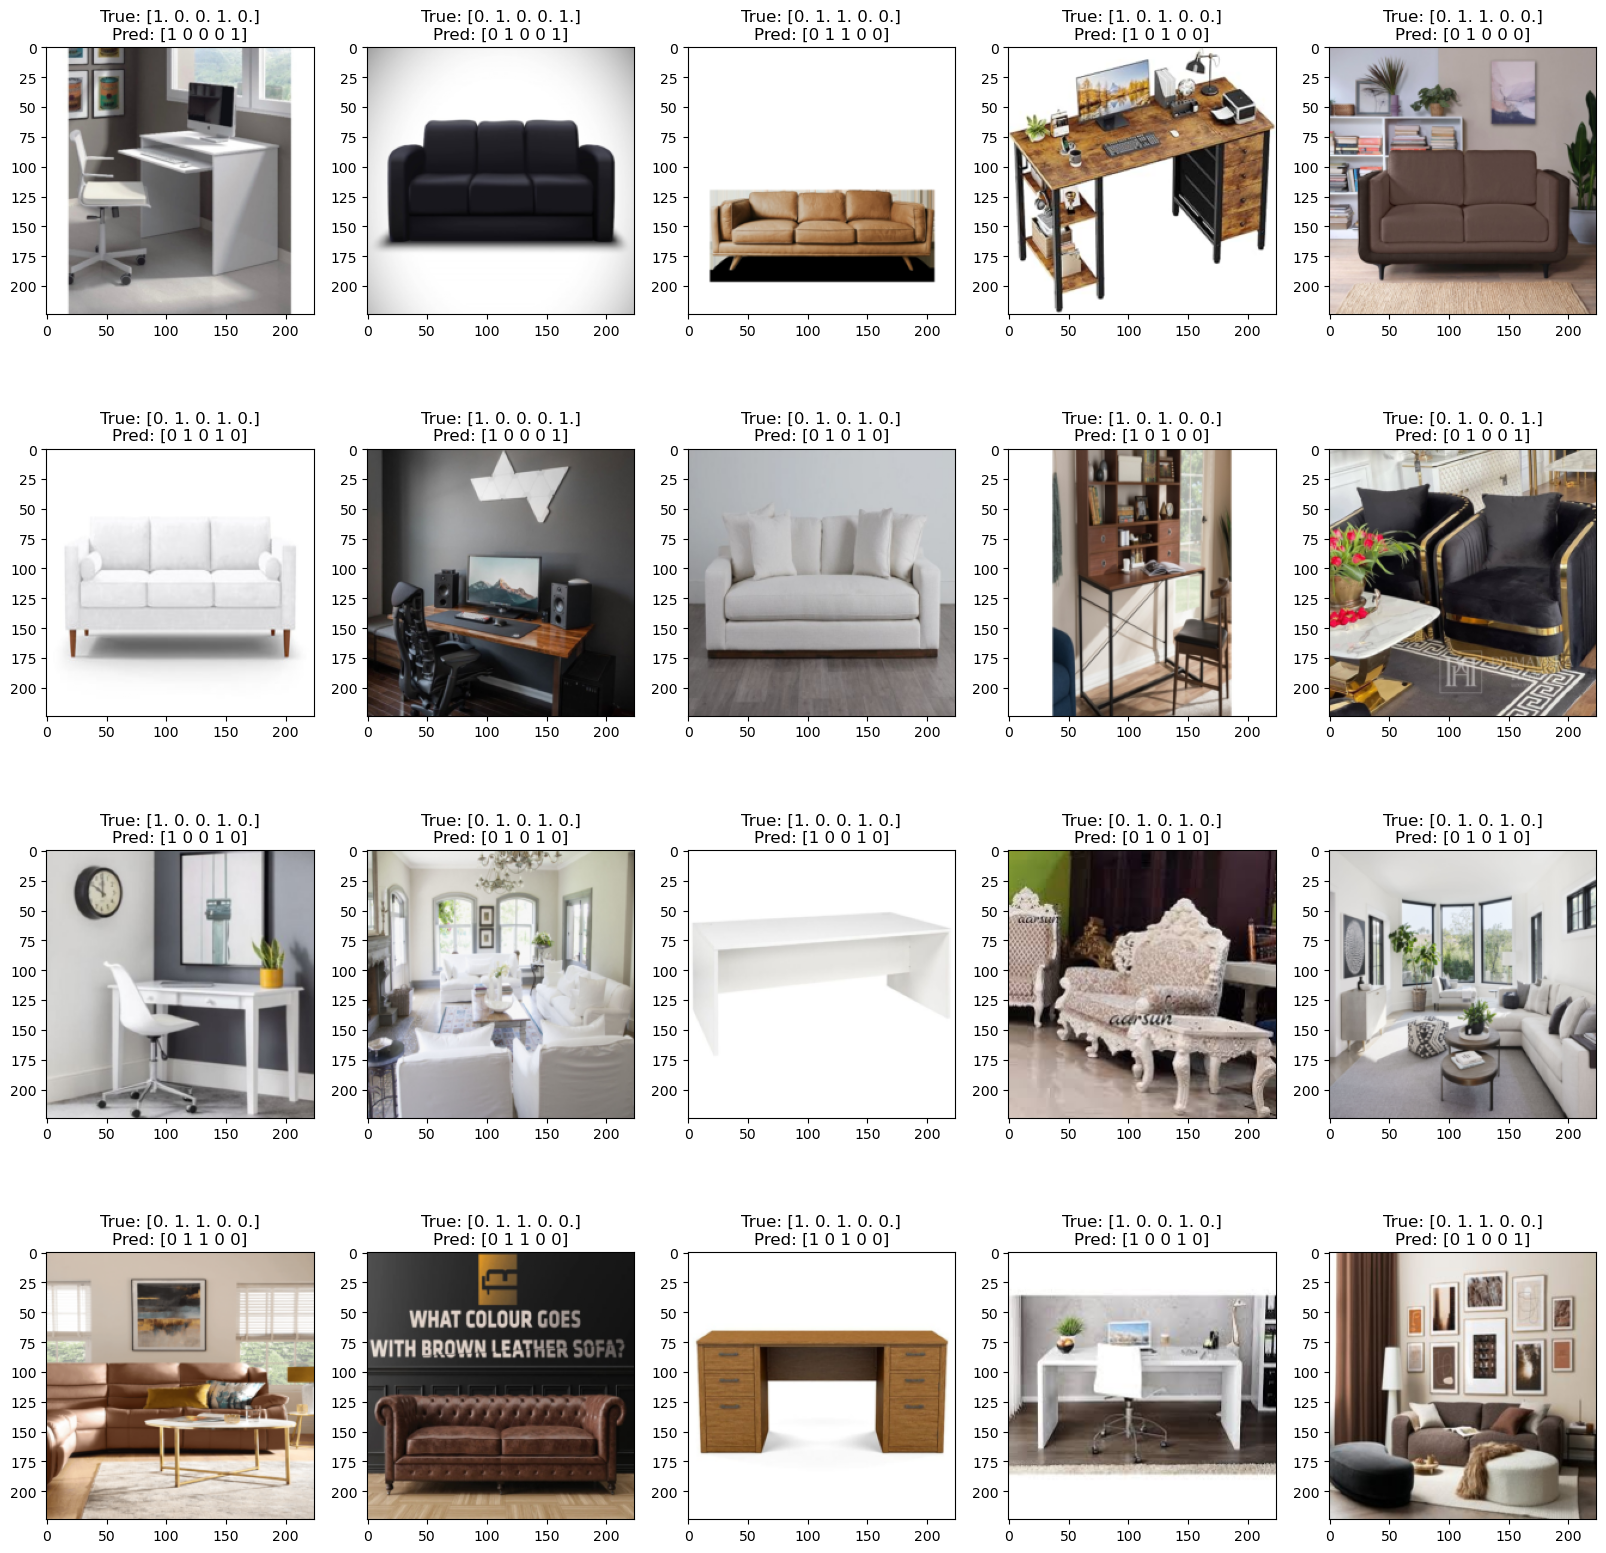

In [25]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {test_dataset[i][1].numpy()}\nPred: {total_preds[i]}')